1- Import the necessary libraries and create a DataFrame from the provided data.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from warnings import simplefilter
simplefilter("ignore")

In [4]:
#Load the dataset:

df = pd.read_csv("data.csv")
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,SALES
0,2018-07-01,39,39077,35094,104,Infuzions Thai Sweetchili Potatomix,2,7.6,110,Infuzions,MIDAGE SINGLES/COUPLES,Premium,15.2
1,2018-07-01,80,80003,78303,99,Pringles Sthrn Friedchicken,2,7.4,134,Pringles,RETIREES,Mainstream,14.8
2,2018-07-01,93,93176,91792,27,Ww Supreme Cheese Corn Chips,2,3.8,200,Woolworths,OLDER FAMILIES,Mainstream,7.6
3,2018-07-01,125,125227,129193,4,Dorito Corn Chp Supreme,2,13.0,380,Doritos,YOUNG SINGLES/COUPLES,Premium,26.0
4,2018-07-01,147,147123,146450,27,Ww Supreme Cheese Corn Chips,2,3.8,200,Woolworths,YOUNG FAMILIES,Mainstream,7.6


In [6]:
# The Dataframe Informatios:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  object 
 1   STORE_NBR         246740 non-null  int64  
 2   LYLTY_CARD_NBR    246740 non-null  int64  
 3   TXN_ID            246740 non-null  int64  
 4   PROD_NBR          246740 non-null  int64  
 5   PROD_NAME         246740 non-null  object 
 6   PROD_QTY          246740 non-null  int64  
 7   TOT_SALES         246740 non-null  float64
 8   PACK_SIZE         246740 non-null  int64  
 9   BRAND             246740 non-null  object 
 10  LIFESTAGE         246740 non-null  object 
 11  PREMIUM_CUSTOMER  246740 non-null  object 
 12  SALES             246740 non-null  float64
dtypes: float64(2), int64(6), object(5)
memory usage: 24.5+ MB


2- Convert the 'DATE' column to a datetime object:

In [8]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["YEARMONTH"] = df["DATE"].dt.strftime("%Y%m").astype("int")

Compile each store's monthly:

1. Total sales
2. Number of customers,
3. Average transactions per customer
4. Average chips per customer
5. Average price per unit

In [9]:
def monthly_store_metrics():
    store_yrmo_group =df.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [10]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3165 non-null   int64  
 1   YEARMONTH        3165 non-null   int64  
 2   TOT_SALES        3165 non-null   float64
 3   nCustomers       3165 non-null   int64  
 4   nTxnPerCust      3165 non-null   float64
 5   nChipsPerTxn     3165 non-null   float64
 6   avgPricePerUnit  3165 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.2 KB


**Pre-Trial Observation as this filter only stores with full 12 months observation**

In [13]:
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head()

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,1.042553,1.234043,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.245614,3.776056
3,1,201810,175.4,39,1.025641,1.307692,3.439216
4,1,201811,184.8,44,1.022727,1.250000,3.360000


3- Calculate the required metrics for each store:

In [14]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
  control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
  corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
  trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
  for control in control_store_nbrs:
    concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
    concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
    concat_df["Trial_Str"] = storeComparison
    concat_df["Ctrl_Str"] = control
    concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
    corrs = pd.concat([corrs, concat_df])
  return corrs

4- Calculate The correlation Scores:

In [15]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
corr_table.head()

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.034928
1,201808,77,1,0.017017
2,201809,77,1,-0.007445
3,201810,77,1,-0.028881
4,201811,77,1,0.007549


5- Iterate the process:

In [16]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
        concat_df = abs(trial_store.reset_index() - control_store)
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [17]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head()
dist_table

,index,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,880,0.939141,1.000000,0.906165,0.716452,0.853885,201807,77,1,0.883128
1,880,0.939447,0.950495,1.000000,0.807168,0.841984,201808,77,1,0.907819
2,880,0.960729,0.831683,0.967117,0.716360,0.686332,201809,77,1,0.832444
3,880,0.985532,0.970297,0.995288,0.943513,0.714699,201810,77,1,0.921866
4,880,0.969303,0.950495,0.880491,0.743772,0.866003,201811,77,1,0.882013
...,...,...,...,...,...,...,...,...,...,...
2,2152,0.209407,0.268293,0.613056,0.797921,0.923369,201809,88,272,0.562409
3,2152,0.358741,0.357724,0.773519,0.861789,0.969082,201810,88,272,0.664171
4,2152,0.292148,0.317073,0.665863,0.792787,0.964449,201811,88,272,0.606464
5,2152,0.370444,0.373984,0.571429,0.722481,0.963101,201812,88,272,0.600288


6- Selecting control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

In [18]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [19]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [20]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [31]:
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n');

     Trial_Str  Ctrl_Str  Corr_Score   index  magnitude  CompScore
217         77       233         1.0  1815.0   0.986702   0.993351
176         77       188         1.0  1307.0   0.980567   0.990283
120         77       131         1.0   624.0   0.977341   0.988670
238         77       255         1.0  2069.0   0.976794   0.988397
192         77       205         1.0  1502.0   0.976706   0.988353 

     Trial_Str  Ctrl_Str  Corr_Score   index  magnitude  CompScore
400         86       155         1.0   815.0   0.964165   0.982082
355         86       109         1.0   265.0   0.955015   0.977507
383         86       138         1.0   611.0   0.950843   0.975421
362         86       116         1.0   349.0   0.950053   0.975027
449         86       207         1.0  1419.0   0.949940   0.974970 

     Trial_Str  Ctrl_Str  Corr_Score  index  magnitude  CompScore
549         88        40         1.0  553.0   0.933101   0.966550
515         88         4         1.0  965.0   0.911153   0.9

In [32]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

Determining the top five highest composite score for each trial based on no. of customers:

In [33]:
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n');

     Trial_Str  Ctrl_Str  Corr_Score   index  magnitude  CompScore
217         77       233         1.0  1815.0   0.991513   0.995757
38          77        41         1.0   420.0   0.961810   0.980905
15          77        17         1.0   698.0   0.960396   0.980198
42          77        46         1.0   361.0   0.960396   0.980198
134         77       145         1.0   792.0   0.957567   0.978784 

     Trial_Str  Ctrl_Str  Corr_Score   index  magnitude  CompScore
400         86       155         1.0   815.0   0.975035   0.987517
465         86       225         1.0  1622.0   0.968100   0.984050
360         86       114         1.0   325.0   0.959778   0.979889
355         86       109         1.0   265.0   0.951456   0.975728
428         86       184         1.0  1162.0   0.951456   0.975728 

     Trial_Str  Ctrl_Str  Corr_Score   index  magnitude  CompScore
733         88       237         1.0  1742.0   0.979094   0.989547
549         88        40         1.0   553.0   0.939605   

In [34]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.994554
           46          0.983852
           188         0.981705
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.984800
           109         0.976618
           225         0.975346
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.968176
           26          0.957020
           58          0.953097
dtype: float64 



Similarities based on total sales:
1. Trial store 77: Store 233, 188, 131
2. Trial store 86: Store 155, 109, 138
3. Trial store 88: Store 40, 4, 26

Similarities based on No. of Customers:
1. Trial store 77: Store 233, 41, 17
2. Trial store 86: Store 155, 225, 114
3. Trial store 88: Store 237, 40, 199

Final SImilarities based on Highest average of both features combined:
1. Trial store 77: Store 233
2. Trial store 86: Store 155
3. Trial store 88: Store 40

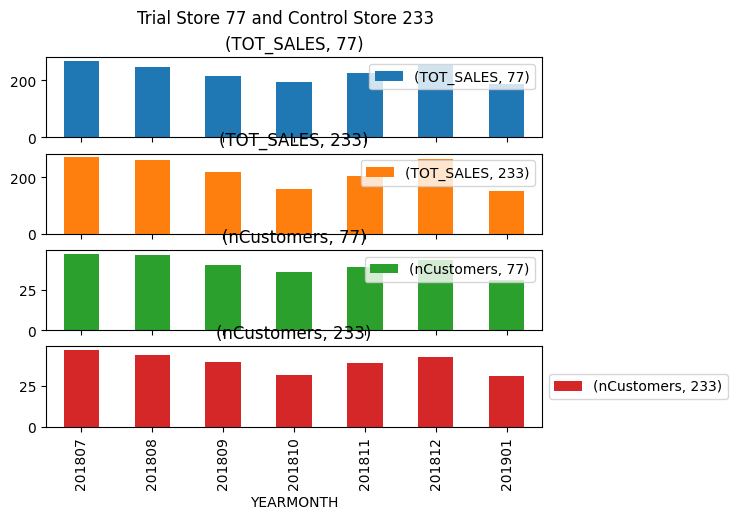

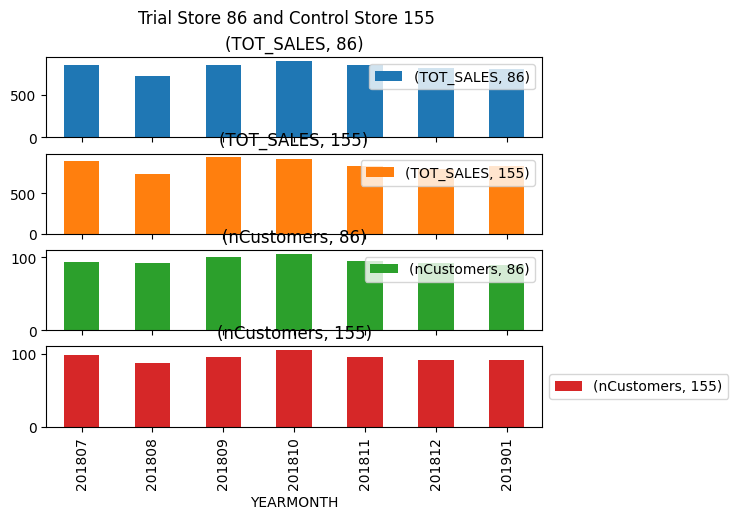

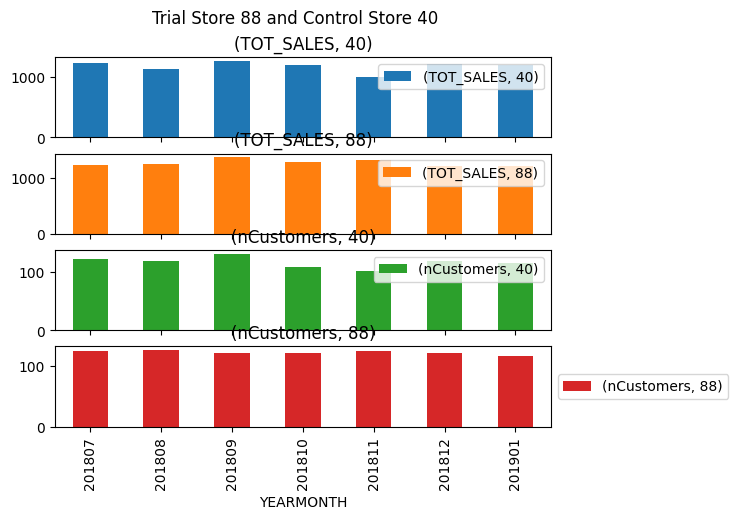

In [35]:
trial_control_dic = {77:233, 86:155, 88:40}
for key, val in trial_control_dic.items():
    store_data = pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])]
    store_data.groupby(["YEARMONTH", "STORE_NBR"]).sum()[["TOT_SALES", "nCustomers"]].unstack().plot.bar(subplots=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.suptitle(f"Trial Store {key} and Control Store {val}")
    plt.show()


comparing the performance of Trial stores to Control stores during the trial period. To ensure their performance is comparable during Trial period, we need to scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial. Starting with TOT_SALES.

In [39]:
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()

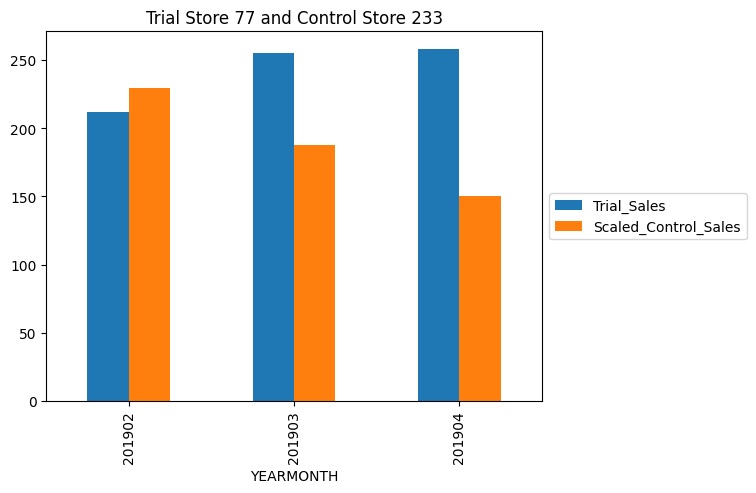

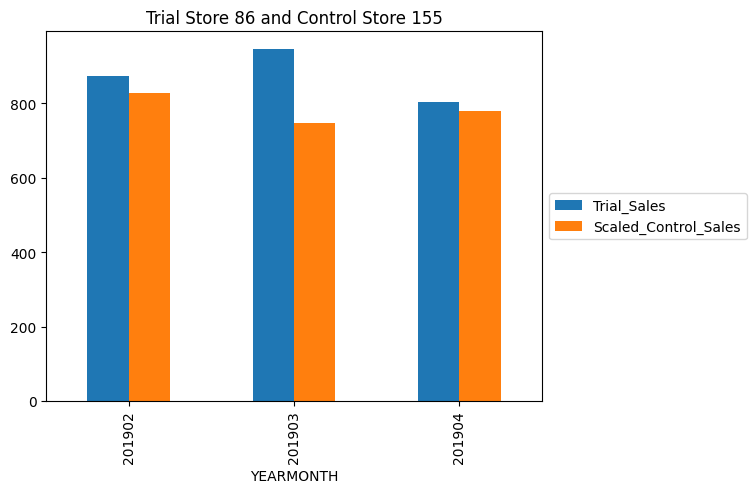

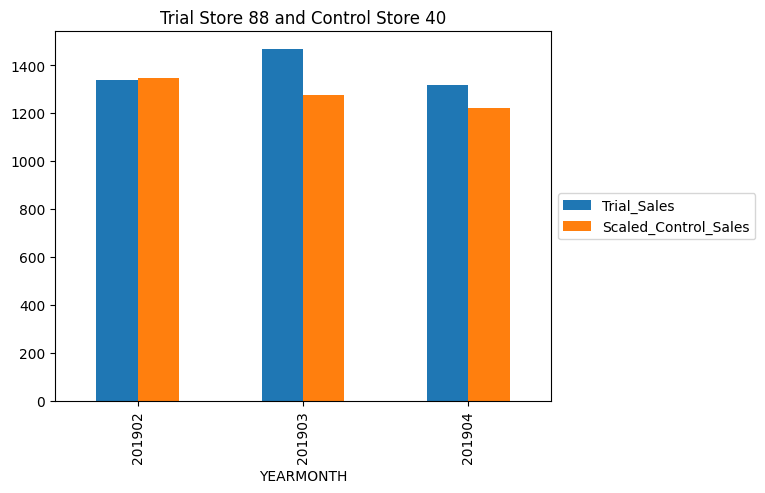

In [40]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(scaler, axis=1)
trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]
percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))


In [41]:
percentage_diff

{77: 1.2778901246373204, 86: 1.1155403148404528, 88: 1.0736785754013871}

In [42]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,229.473346,77,211.6,-0.081045,trial
8,233,201903,187.779277,77,255.1,0.304014,trial
9,233,201904,149.932291,77,258.1,0.530192,trial
19,155,201902,827.019610,86,872.8,0.053865,trial
20,155,201903,745.561872,86,945.4,0.236360,trial
21,155,201904,778.028321,86,804.0,0.032833,trial
31,40,201902,1346.153002,88,1339.6,-0.004880,trial
32,40,201903,1273.550526,88,1467.0,0.141176,trial
33,40,201904,1220.924472,88,1317.0,0.075712,trial


Check significance of Trial minus Control stores TOT_SALES Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
If <5%, it is significantly different. If >5%, it is not significantly different (similar).

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
Mean is mean of Percentage Difference during pre-trial.
Standard deviation is stdev of Percentage Difference during pre-trial.
Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [43]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=-0.36013226673707055, pvalue=0.7312292961250693) 

Store 155
Ttest_indResult(statistic=1.263200805017718, pvalue=0.2495986218683616) 

Store 233
Ttest_indResult(statistic=1.2851941918470577, pvalue=0.2540387701484951) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [44]:
a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]

Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [45]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=2.4926005499695936e-15, pvalue=0.999999999999998) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [46]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.8435806220494315
201903 : 2.4904464734755805
201904 : 4.448806995302806


Trial store: 86 , Control store: 155
201902 : 1.3077596199049673
201903 : 5.828582596615286
201904 : 0.7867590051021537


Trial store: 88 , Control store: 40
201902 : -0.06747939544187861
201903 : 1.4413280336576249
201904 : 0.7650631287827934


Critical t-value for 95% confidence interval:
1.9431802803927818


There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

March trial months for trial store 86

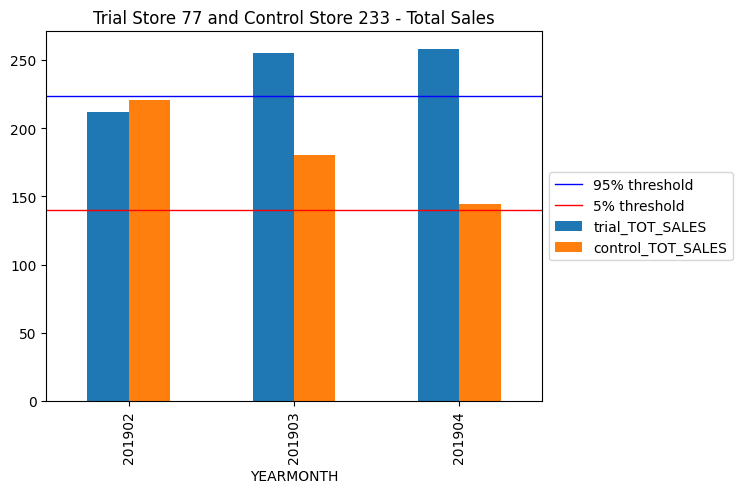

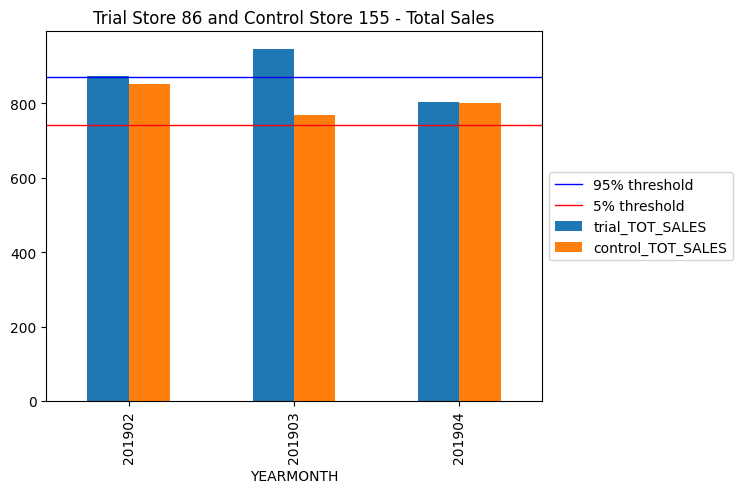

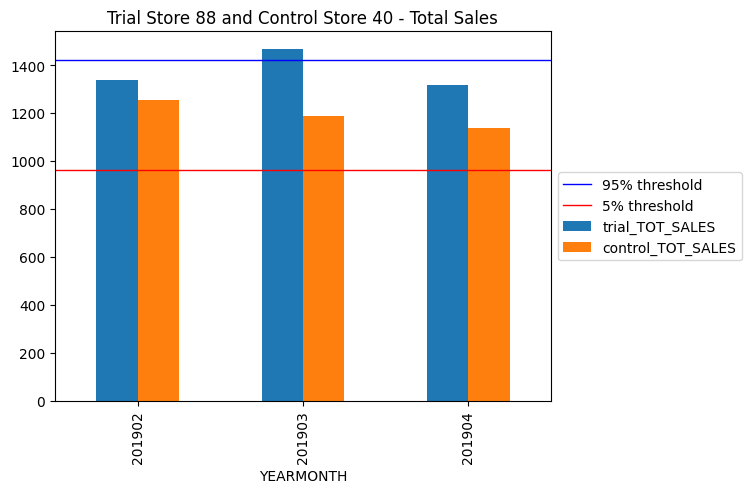

In [47]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    comb = b[["YEARMONTH", "trial_TOT_SALES"]].merge(a[["YEARMONTH", "control_TOT_SALES"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")


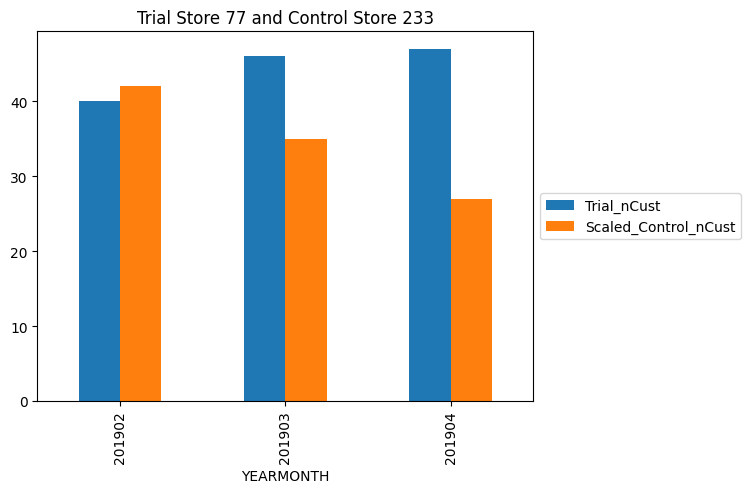

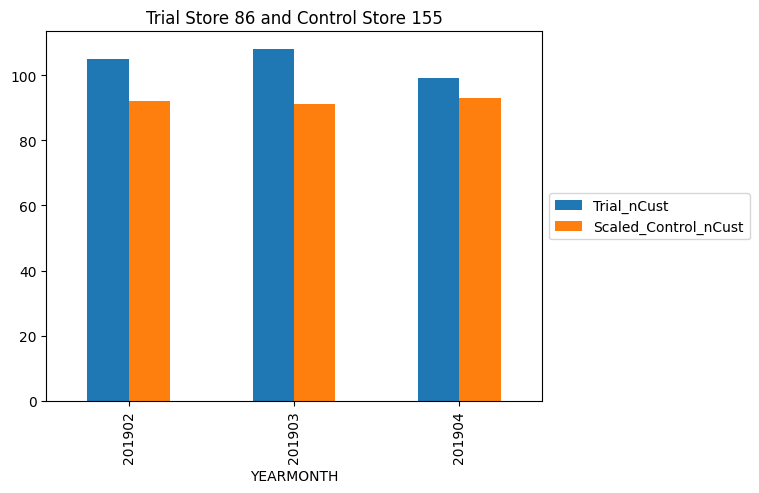

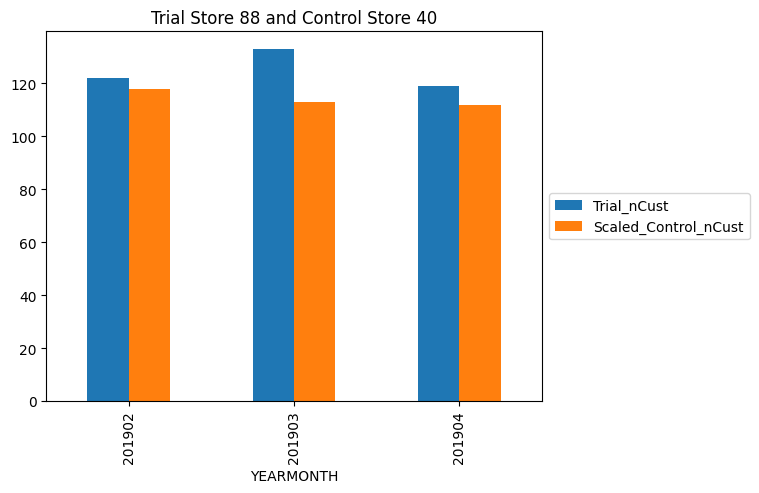

In [48]:
# Group the data by store number and calculate the sum of nCustomers
store_ncust_sum = pretrial_full_observ.groupby("STORE_NBR")["nCustomers"].sum()

# Calculate the ratios for each store pair
ncust_ratios = {77: store_ncust_sum[77] / store_ncust_sum[233],
                86: store_ncust_sum[86] / store_ncust_sum[155],
                88: store_ncust_sum[88] / store_ncust_sum[40]}

# Filter the data for control stores
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

# Scale the nCustomers for control stores
scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: row["nCustomers"] * ncust_ratios.get(row["STORE_NBR"], 1), axis=1)

# Filter the data for trial and pretrial periods
trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

trial_control_dic = {77: 233, 86: 155, 88: 40}
ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]], on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledNcust": "Scaled_Control_nCust", "nCustomers": "Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store " + str(trial) + " and Control Store " + str(control))


In [49]:
ncust_percentage_diff

{77: 1.2788461538461537, 86: 1.1304347826086956, 88: 1.0903790087463556}

In [50]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "nCustomers"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,201902,42,77,40,-0.048780,trial
8,233,201903,35,77,46,0.271605,trial
9,233,201904,27,77,47,0.540541,trial
19,155,201902,92,86,105,0.131980,trial
20,155,201903,91,86,108,0.170854,trial
21,155,201904,93,86,99,0.062500,trial
31,40,201902,118,88,122,0.033333,trial
32,40,201903,113,88,133,0.162602,trial
33,40,201904,112,88,119,0.060606,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [51]:
def perform_ttest(store_num, pretrial_data, trial_data, alpha=0.05):
    print(f"Store {store_num}")
    
    pretrial_store_data = pretrial_data[pretrial_data["STORE_NBR"] == store_num]["ScaledNcust"]
    trial_store_data = trial_data[trial_data["STORE_NBR"] == store_num]["ScaledNcust"]
    
    t_stat, p_value = ttest_ind(pretrial_store_data, trial_store_data, equal_var=False)
    print(f"t-statistic: {t_stat}, p-value: {p_value}\n")
    
    df = min(len(pretrial_store_data), len(trial_store_data)) - 1
    critical_t_values = t.ppf((alpha/2, 1-alpha/2), df)
    print(f"Critical t-value for 95% confidence interval: {critical_t_values}\n")

# Step 1
for num in [40, 155, 233]:
    perform_ttest(num, pretrial_scaled_ncust_control_stores, trial_scaled_ncust_control_stores)


Store 40
t-statistic: 0.5635718480314665, p-value: 0.5885700785723761

Critical t-value for 95% confidence interval: [-4.30265273  4.30265273]

Store 155
t-statistic: 1.4443707614569463, p-value: 0.19292354514578539

Critical t-value for 95% confidence interval: [-4.30265273  4.30265273]

Store 233
t-statistic: 0.9728013089400634, p-value: 0.3987820971176183

Critical t-value for 95% confidence interval: [-4.30265273  4.30265273]



In [52]:
def perform_ttest_step2(trial, control, pretrial_data, alpha=0.05):
    print(f"Trial store: {trial}, Control store: {control}")
    
    trial_store_data = pretrial_data[pretrial_data["STORE_NBR"] == trial]["nCustomers"]
    control_store_data = pretrial_data[pretrial_data["STORE_NBR"] == control]["ScaledNcust"]
    
    t_stat, p_value = ttest_ind(trial_store_data, control_store_data, equal_var=True)
    print(f"t-statistic: {t_stat}, p-value: {p_value}\n")
    
    df = len(trial_store_data) - 1
    critical_t_values = t.ppf((alpha/2, 1-alpha/2), df)
    print(f"Critical t-value for 95% confidence interval: {critical_t_values}\n")



# Step 2
for trial, control in trial_control_dic.items():
    perform_ttest_step2(trial, control, pretrial_scaled_ncust_control_stores)



Trial store: 77, Control store: 233
t-statistic: nan, p-value: nan

Critical t-value for 95% confidence interval: [nan nan]

Trial store: 86, Control store: 155
t-statistic: nan, p-value: nan

Critical t-value for 95% confidence interval: [nan nan]

Trial store: 88, Control store: 40
t-statistic: nan, p-value: nan

Critical t-value for 95% confidence interval: [nan nan]



In [53]:
def perform_ttest_step3(trial, control, data):
    print(f"Trial store: {trial}, Control store: {control}")
    
    temp_pre = data[(data["c_STORE_NBR"] == control) & (data["trial_period"] == "pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    
    for t_month in data[data["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = data[(data["YEARMONTH"] == t_month) & (data["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(f"{t_month}: {(float(pdif) - mean) / std}")
    
    print('\n')
    print("Critical t-value for 95% confidence interval:")
    conf_intv_95 = t.ppf(0.95, df=len(temp_pre) - 1)
    print(conf_intv_95, '\n')
    
# Step 3
for trial, control in trial_control_dic.items():
    perform_ttest_step3(trial, control, scaledncust_vs_trial)

Trial store: 77, Control store: 233
201902: -1.6043572751369122
201903: 5.54101792883419
201904: 11.53893677130597


Critical t-value for 95% confidence interval:
1.9431802803927818 

Trial store: 86, Control store: 155
201902: 3.775545866554842
201903: 4.914397382877384
201904: 1.7401009874188225


Critical t-value for 95% confidence interval:
1.9431802803927818 

Trial store: 88, Control store: 40
201902: -0.08887232214424588
201903: 1.4493668505839379
201904: 0.2356618429424893


Critical t-value for 95% confidence interval:
1.9431802803927818 



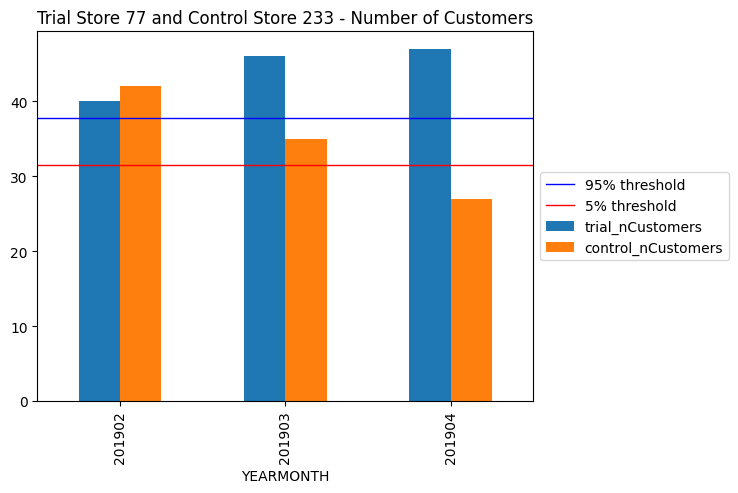

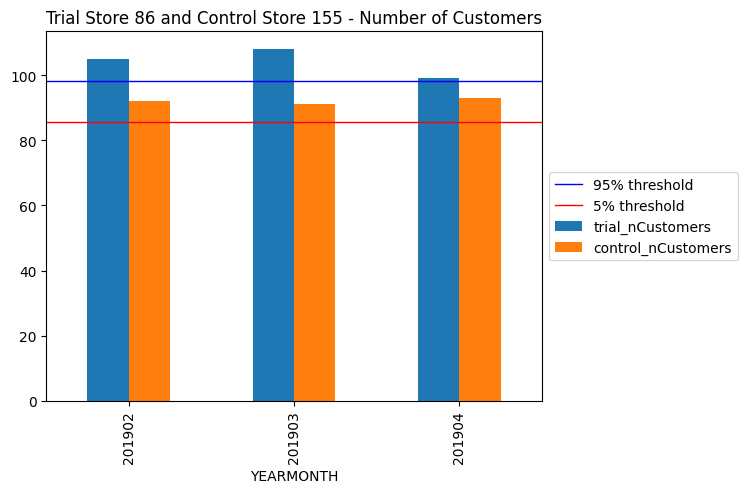

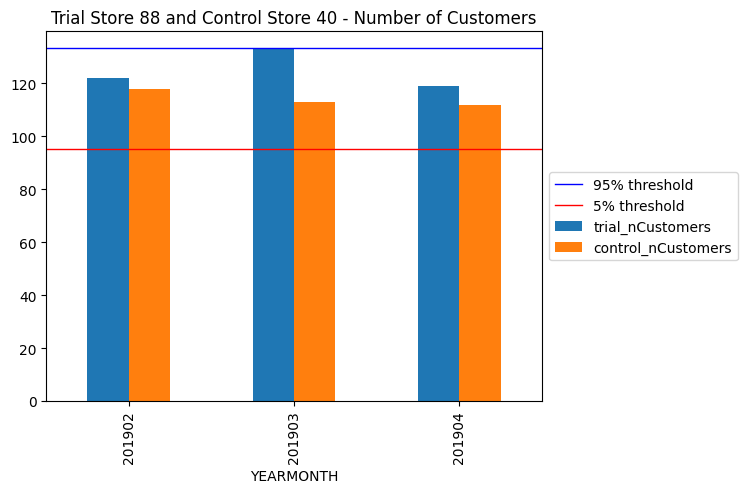

In [55]:
def plot_trial_vs_control(trial, control, trial_data, control_data, scaled_data):
    a = control_data[control_data["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_data[trial_data["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]], on="YEARMONTH").set_index("YEARMONTH")
    ax = comb.plot.bar()
    
    cont_sc_ncust = control_data[control_data["STORE_NBR"] == control]["nCustomers"]
    std = scaled_data[(scaled_data["c_STORE_NBR"] == control) & (scaled_data["trial_period"] == "pre")]["nCust_Percentage_Diff"].std()
    
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    
    ax.axhline(y=thresh95, linewidth=1, color='b', label="95% threshold")
    ax.axhline(y=thresh5, linewidth=1, color='r', label="5% threshold")
    
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_title(f"Trial Store {trial} and Control Store {control} - Number of Customers")
    plt.savefig(f"TS {trial} and CS {control} - nCustomers.png", bbox_inches="tight")
    plt.show()

# Generate visualizations
for trial, control in trial_control_dic.items():
    plot_trial_vs_control(trial, control, trial_full_observ, trial_scaled_ncust_control_stores, scaledncust_vs_trial)


## Conclusion:

After analyzing the data, we found that trial stores 77 and 86 had sales for February, March, and April that exceeded the 95% threshold of their respective control stores (store 233 for trial store 77 and store 155 for trial store 86). 

However, trial store 88 did not show a significant increase in total sales or number of customers during the trial period compared to its control store (store 40). It is possible that there were factors specific to trial store 88 that affected its performance during the trial period.


Overall, the trial showed a positive and significant result, with trial stores 77 and 86 performing well during the trial period. These findings suggest that the trial was effective in increasing sales and attracting more customers to the trial stores.